In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('Hotel_bookings.csv')

In [3]:
df.head()

,Unnamed: 0,hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,market_segment,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces
0,0,Resort Hotel,0,342,0,0,2,0.0,0,Direct,...,0,0,C,C,3,No Deposit,0,Transient,0.0,0
1,1,Resort Hotel,0,737,0,0,2,0.0,0,Direct,...,0,0,C,C,4,No Deposit,0,Transient,0.0,0
2,2,Resort Hotel,0,7,0,1,1,0.0,0,Direct,...,0,0,A,C,0,No Deposit,0,Transient,75.0,0
3,3,Resort Hotel,0,13,0,1,1,0.0,0,Corporate,...,0,0,A,A,0,No Deposit,0,Transient,75.0,0
4,4,Resort Hotel,0,14,0,2,2,0.0,0,Online TA,...,0,0,A,A,0,No Deposit,0,Transient,98.0,0


In [4]:
df.dtypes

Unnamed: 0                          int64
hotel                              object
is_canceled                         int64
lead_time                           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
days_in_waiting_list                int64
customer_type                      object
adr                               float64
required_car_parking_spaces         int64
dtype: object

In [5]:
df.isnull().sum()/len(df)

Unnamed: 0                        0.000000
hotel                             0.000000
is_canceled                       0.000000
lead_time                         0.000000
stays_in_weekend_nights           0.000000
stays_in_week_nights              0.000000
adults                            0.000000
children                          0.000034
babies                            0.000000
market_segment                    0.000000
distribution_channel              0.000000
is_repeated_guest                 0.000000
previous_cancellations            0.000000
previous_bookings_not_canceled    0.000000
reserved_room_type                0.000000
assigned_room_type                0.000000
booking_changes                   0.000000
deposit_type                      0.000000
days_in_waiting_list              0.000000
customer_type                     0.000000
adr                               0.000000
required_car_parking_spaces       0.000000
dtype: float64

In [6]:
df=df.fillna(0)

In [8]:
def family(data):
    if ((data['adults'] > 0) & (data['children'] > 0)):
        val = 1
    elif ((data['adults'] > 0) & (data['babies'] > 0)):
        val = 1
    else:
        val = 0
    return val

df['new_is_family'] = df.apply(family, axis=1)

In [9]:
# converted Room type category to numerical baased the Average Daily Rate

unique_room_list = list(df.groupby(by='assigned_room_type').agg({'adr': 'mean'}).sort_values(by='adr', ascending=False).index)
mapper = {}
k = 10
for index, i in enumerate(unique_room_list):
    mapper[unique_room_list[index]] = k
    k = k - 1


df['assigned_room_type'].replace(mapper, inplace=True)
df['reserved_room_type'].replace(mapper, inplace=True)


In [10]:

df['new_room_difference'] = df['reserved_room_type'] - df['assigned_room_type']

# new_room_difference: It is the difference between the code of the room type reserved (reserved_room_type) and
# the one assigned at check-in (assigned_room_type). If the values are the same, the difference will be 0, 
#  indicating that the room assigned was the one originally reserved.


# new_total_people: It is the sum of the number of adults, children, and babies (adults, 
df['new_total_people'] = df['adults'] + df['children'] + df['babies']

#new_total_stay_day: It is the total number of days (stays_in_weekend_nights plus stays_in_week_nights)
#the guests will stay at the hotel.

df['new_total_stay_day'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

In [11]:
df['new_room_difference_cat'] = np.nan
df.loc[df[df['new_room_difference'] > 0].index, 'new_room_difference_cat'] = 1
df.loc[df[df['new_room_difference'] < 0].index, 'new_room_difference_cat'] = -1
df.loc[df[df['new_room_difference'] == 0].index, 'new_room_difference_cat'] = 0

#Drop the rows  where coustmer type is Group and total Numbersis 1 is not accurate data

df.drop(df[(df['customer_type'] == 'Group') & (df['new_total_people'] == 1)].index, axis=0, inplace=True)

In [12]:

df['new_is_weekend'] = np.where([(df['stays_in_weekend_nights'] > 0) & (df['stays_in_week_nights'] == 0)], 1, 0)[0]

In [13]:
df['new_is_weekday'] = np.where([(df['stays_in_weekend_nights'] == 0) & (df['stays_in_week_nights'] > 0)], 1, 0)[0]


In [14]:
df['new_is_weekend_and_weekdays'] = np.where([(df['stays_in_weekend_nights'] > 0) & (df['stays_in_week_nights'] > 0)], 1, 0)[0]

In [15]:
df['new_want_parking_space'] = np.where(df['required_car_parking_spaces'] > 0, 1, 0)
df['new_adr_per_person'] = df['adr'] / (df['adults']+df['children'])
df = df.drop(df[(df['adults']==0) & (df['children']==0)].index)

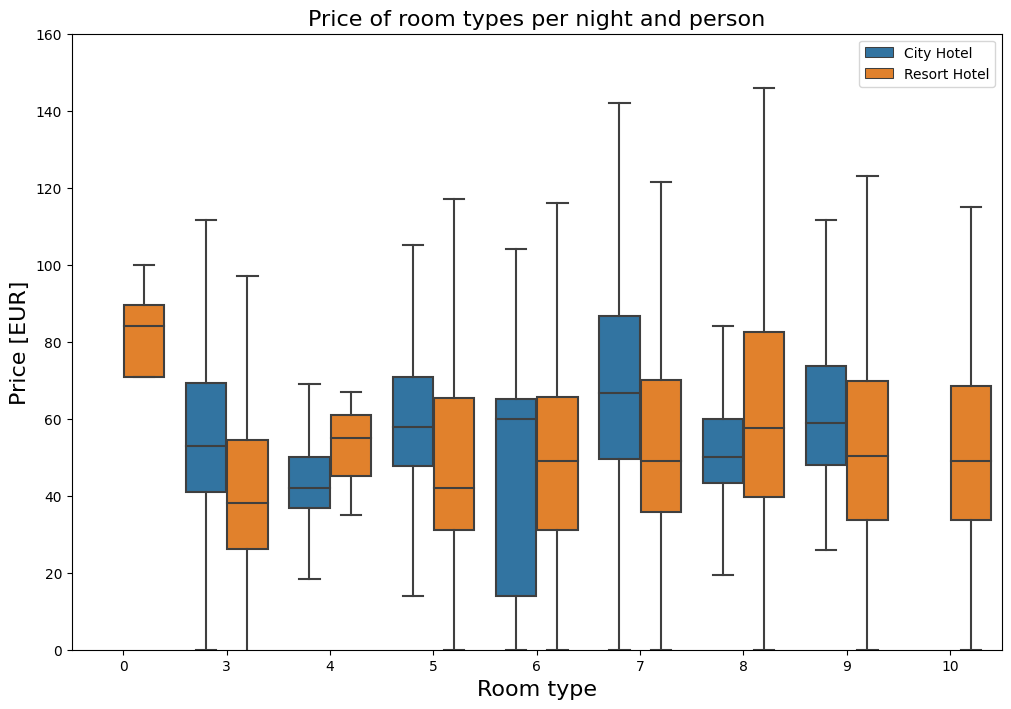

In [16]:
full_data_guests = df.loc[df["is_canceled"] == 0] # only actual guests
room_prices = full_data_guests[["hotel", "reserved_room_type", "new_adr_per_person"]].sort_values("reserved_room_type")

# boxplot:
plt.figure(figsize=(12, 8))
sns.boxplot(x="reserved_room_type",
            y="new_adr_per_person",
            hue="hotel",
            data=room_prices,
            hue_order=["City Hotel", "Resort Hotel"],
            fliersize=0)
plt.title("Price of room types per night and person", fontsize=16)
plt.xlabel("Room type", fontsize=16)
plt.ylabel("Price [EUR]", fontsize=16)
plt.legend(loc="upper right")
plt.ylim(0, 160)
plt.savefig('your_figure.png')
plt.show()

In [17]:
df.drop(columns=['adults', 'babies', 'children'], inplace=True, axis=1)

df.drop(columns= [ 'stays_in_weekend_nights', 'stays_in_week_nights', 'required_car_parking_spaces',
                 'distribution_channel', 'reserved_room_type', 'assigned_room_type'], axis=1, inplace=True)


In [18]:

df.drop('Unnamed: 0',axis=1,inplace=True)

In [19]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr', 'new_is_family',
       'new_room_difference', 'new_total_people', 'new_total_stay_day',
       'new_room_difference_cat', 'new_is_weekend', 'new_is_weekday',
       'new_is_weekend_and_weekdays', 'new_want_parking_space',
       'new_adr_per_person'],
      dtype='object')

In [20]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [21]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [22]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]

for col in binary_cols:
    label_encoder(df, col)

cat_cols, num_cols, cat_but_car = grab_col_names(df)
ohe_cols = [col for col in cat_cols if 12 >= df[col].nunique() > 2]
ohe_cols.remove('new_room_difference_cat')
df = one_hot_encoder(df, ohe_cols, drop_first=True)

Observations: 119039
Variables: 22
cat_cols: 12
num_cols: 10
cat_but_car: 0
num_but_cat: 9


In [23]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head(10)

,hotel,is_canceled,lead_time,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,new_is_family,...,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,1,0,2.225270,0,-0.103159,-0.090597,4.357042,-0.131948,-2.022898,0,...,1,0,0,0,0,0,0,0,1,0
1,1,0,5.921512,0,-0.103159,-0.090597,5.923549,-0.131948,-2.022898,0,...,1,0,0,0,0,0,0,0,1,0
2,1,0,-0.909517,0,-0.103159,-0.090597,-0.342479,-0.131948,-0.535729,0,...,1,0,0,0,0,0,0,0,1,0
3,1,0,-0.853371,0,-0.103159,-0.090597,-0.342479,-0.131948,-0.535729,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,-0.844014,0,-0.103159,-0.090597,-0.342479,-0.131948,-0.079664,0,...,0,0,0,1,0,0,0,0,1,0
5,1,0,-0.844014,0,-0.103159,-0.090597,-0.342479,-0.131948,-0.079664,0,...,0,0,0,1,0,0,0,0,1,0
6,1,0,-0.975020,0,-0.103159,-0.090597,-0.342479,-0.131948,0.098796,0,...,1,0,0,0,0,0,0,0,1,0
7,1,0,-0.890802,0,-0.103159,-0.090597,-0.342479,-0.131948,0.019480,0,...,1,0,0,0,0,0,0,0,1,0
8,1,1,-0.179626,0,-0.103159,-0.090597,-0.342479,-0.131948,-0.396927,0,...,0,0,0,1,0,0,0,0,1,0
9,1,1,-0.273202,0,-0.103159,-0.090597,-0.342479,-0.131948,0.069053,0,...,0,0,1,0,0,0,0,0,1,0


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# split the data
X=df.drop('is_canceled',axis=1)
y=df['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
knn_acc = accuracy_score(y_test, knn_pred)

In [ ]:
print('KNN accuracy:', knn_acc)

In [ ]:
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

dt.fit(X_train, y_train)
rf.fit(X_train, y_train)


dt_pred = dt.predict(X_test)
rf_pred = rf.predict(X_test)
                     
                     
dt_acc = accuracy_score(y_test, dt_pred)
rf_acc = accuracy_score(y_test, rf_pred)
                     
                     
print('Decision Tree accuracy:', dt_acc)
print('Random Forest accuracy:', rf_acc)

In [ ]:
svm = SVC()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)
print('SVM accuracy:', svm_acc)